In [1]:
import numpy as np
import tifffile as tf
import ntpath
import os
import matplotlib.pyplot as plt
import sys
import time
import math
from paq2py import *
from parse_markpoints import ParseMarkpoints
from utils import *
import seaborn as sns
from random import randint
from scipy import stats
import csv

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

%matplotlib notebook

In [2]:
paq_path = r'/media/jamesrowland/DATA/plab/2019-02-19_RL025_S2imS1stim/2019-03-19_RL025_photostim_006.paq'
s2p_path = r'/media/jamesrowland/DATA/plab/2019-02-19_RL025_S2imS1stim/artifactRemoved/suite2p'
naparm_path = r'/media/jamesrowland/DATA/plab/2019-02-19_RL025_S2imS1stim/2019-03-19_RL025_NAPARM_005'
csv_path = '/media/jamesrowland/DATA/plab/s2_100_shots/sigCellRaw.csv'

In [3]:
paq = paq_read(paq_path)
raw, stat = s2p_loader(s2p_path, subtract_neuropil=False)
arr = dfof(raw)
num_units = arr.shape[0]

arr.shape

# raw = read_fiji(csv_path)
# #help with enumeration
# arr = np.vstack([raw]*3)
# num_units = 264
# arr = dfof(arr)
# arr = np.squeeze(arr)
# arr.shape

/home/jamesrowland/Documents/Code/Vape/utils.py:21: RuntimeWarning: invalid value encountered in float_scalars
  dfof_arr.append([((f - F) / F) * 100 for f in trace])


(294, 31368)

In [4]:
xml_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.xml'))
gpl_path = next(os.path.join(naparm_path, file) for file in os.listdir(naparm_path) if file.endswith('.gpl'))

In [5]:
clock_idx = paq['chan_names'].index('frame_clock')
clock_voltage = paq['data'][clock_idx, :]

#digitise frame clock, two clocks should not occur less than 10ms apart or more than 100ms apart
frame_clock = digitise_trigger(clock_voltage, min_time = 0.01*paq['rate'], max_time = 0.1*paq['rate'])


In [6]:
m2p_idx = paq['chan_names'].index('markpoints2packio')
m2p_volts = paq['data'][m2p_idx, :]

#stims should not occur within 1ms of each other
stim_times = digitise_trigger(m2p_volts, min_time = 0.001*paq['rate'])

markpoints = ParseMarkpoints(xml_path=xml_path, gpl_path=gpl_path)
assert len(stim_times) == int(markpoints.iterations)

plt.figure()
plt.plot(m2p_volts)
plt.show()
len(stim_times)

<IPython.core.display.Javascript object>

100

In [7]:
# assume all group durations the same
single_duration = float(markpoints.durations[0]) #ms
repetitions = float(markpoints.repetitions[0])
n_groups = len(markpoints.durations)
duration_ms = single_duration * repetitions * n_groups

#correct this based on txt file
duration_ms = 1200

duration_samples = (duration_ms / 1000) * paq['rate']

single_duration
n_groups

8

In [8]:
#use this to remove frames during stim based on paq
to_remove = []

for stim in stim_times:

    #the sample time of the frame immediately preceeding stim
    stim_start_frame = next(frame_clock[i-1] for i,sample in enumerate(frame_clock) if sample - stim > 0)

    # frame indexes that fall during the stim
    in_stim = np.where((frame_clock >= stim_start_frame) & (frame_clock <= stim + duration_samples))[0]
    
    in_stim = np.append(in_stim, in_stim[-1] + 1)
    in_stim = np.append(in_stim, in_stim[-1] + 1)
    
    [to_remove.append(f) for f in in_stim]
    
arr[:, to_remove] = np.nan


In [9]:
stim_start_frames = []

for stim in stim_times:

    #the index of the frame immediately preceeding stim
    stim_start_frame = next(i-1 for i,sample in enumerate(frame_clock) if sample - stim > 0)
    
    stim_start_frames.append(stim_start_frame)
    
assert len(stim_start_frames) == int(markpoints.iterations)

stim_start_frames = np.array(stim_start_frames)
#assert max(stim_start_frames) < arr.shape[1]


In [22]:
pre_frames = 50
post_frames = 100

all_trials = []
stas = []
dfs = []
t_tests = []
mann_whits = []

count = 0
    
for i, unit in enumerate(arr):

    trials = []
    df = []
    
    # observations before stim
    pre_obs = []
    #observations after stim
    post_obs = []

    for stim in stim_start_frames:
        
        pre_stim  = unit[stim-pre_frames: stim]
        post_stim = unit[stim: stim + post_frames]
        
        pre_mean = np.mean(pre_stim)
        post_mean = np.mean(post_stim)
        df.append(post_mean - pre_mean)

        [pre_obs.append(ob) for ob in pre_stim]
        [post_obs.append(ob) for ob in post_stim]
                          
        trial = unit[stim-pre_frames : stim+post_frames]
        trials.append(trial)
  
    trials = np.array(trials)
    all_trials.append(trials)

    sta = np.mean(trials, 0)        
    stas.append(sta)
    
    dfs.append(np.mean(df))
    pre_obs = [x for x in pre_obs if ~np.isnan(x)]
    post_obs = [x for x in post_obs if ~np.isnan(x)]
    
    t_test = stats.ttest_ind(pre_obs, post_obs)
    mann_whit = stats.mannwhitneyu(pre_obs, post_obs)
    
    t_tests.append(t_test)
    mann_whits.append(mann_whit)
    
        
    if t_test[1] < 0.05 / num_units:
        count += 1
        
 
dfs = np.array(dfs)
stas = np.array(stas)
all_trials = np.array(all_trials)




/home/jamesrowland/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:4879: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd


In [23]:
p_vals = [t[1] for t in mann_whits]
idx = range(len(p_vals))

for p,i in sorted(zip(p_vals,idx)):
    if p < 0.05 / num_units:
        print('unit {} has P value of {}'.format(i, p))


unit 274 has P value of 0.0
unit 46 has P value of 3.085711361865602e-32
unit 0 has P value of 2.0275020346217594e-28
unit 27 has P value of 1.3587813733776676e-22
unit 66 has P value of 5.883516362446876e-22
unit 104 has P value of 6.763424822082341e-22
unit 14 has P value of 9.95213151683015e-22
unit 140 has P value of 5.836904776509298e-21
unit 61 has P value of 2.2679204158009844e-20
unit 38 has P value of 2.8642918784794603e-18
unit 159 has P value of 1.043869164765222e-17
unit 174 has P value of 2.429665838874313e-17
unit 99 has P value of 6.97413060107405e-17
unit 257 has P value of 1.5242484247878673e-16
unit 253 has P value of 1.649597055926958e-16
unit 87 has P value of 2.6485111188371844e-16
unit 5 has P value of 5.183738774682294e-16
unit 21 has P value of 2.668355779954685e-15
unit 15 has P value of 6.632024330323047e-15
unit 225 has P value of 5.043486929088779e-13
unit 112 has P value of 8.048555470867871e-13
unit 144 has P value of 9.19451397972579e-13
unit 179 has P va

<IPython.core.display.Javascript object>


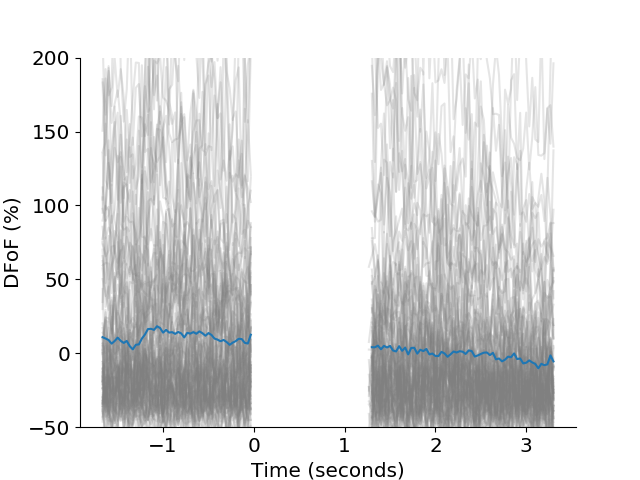

In [24]:
unit = 46

frame_rate = 30
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

plt.figure()

sta = stas[unit]
[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
plt.plot(x_axis, sta)
plt.xlabel('Time (seconds)')
plt.ylabel('DFoF (%)')
plt.ylim((-50,200))
#plt.plot([pre_frames] * 100, np.linspace(min(sta), max(sta), 100), '--')
sns.despine()
plt.savefig('s2_responsive_cell.pdf')

In [13]:
1/0

ZeroDivisionError: division by zero

In [ ]:
unit = 40
frame_rate = 30
x_axis = (np.arange(len(sta)) - pre_frames) / frame_rate

plt.figure(figsize=(7,7))
sta = stas[unit]
[plt.plot(x_axis, t, c='grey', alpha=0.2) for t in all_trials[unit,:,:]]
plt.plot(x_axis, sta)
plt.xlabel('Time (seconds)')
plt.ylabel('DFoF (%)')
#plt.plot([pre_frames] * 100, np.linspace(min(sta), max(sta), 100), '--')
sns.despine()
plt.savefig('s2_responsive_cell.pdf')


In [ ]:
for i,s in enumerate(stat):
    if s['original_index'] == 126:
        print(i)
        print(p_vals[i])